#### Goal
Goal of this notebook is to narrow down the features. The results will then be used to trim down what columns the build script keeps.

What we can drop:

sup_num
sup_action
sup_cd
sup_desc

In [206]:
from scipy.stats.mstats import winsorize
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_style('darkgrid')

In [77]:
# Load in 2019 data from cleaned h5 file
bexar_df = pd.read_hdf('../data/processed/bexar_merged_df.h5')

In [78]:
print(bexar_df.columns)

Index(['prop_id', 'prop_type_cd', 'prop_val_yr', 'sup_num', 'sup_action',
       'sup_cd', 'sup_desc', 'geo_id', 'py_owner_id', 'py_owner_name',
       'partial_owner', 'udi_group', 'py_addr_line1', 'py_addr_line2',
       'py_addr_line3', 'py_addr_city', 'py_addr_state', 'py_addr_country',
       'py_addr_zip', 'py_addr_zip_cass', 'py_addr_zip_rt',
       'py_confidential_flag', 'py_address_suppress_flag',
       'py_addr_ml_deliverable', 'situs_street_prefx', 'situs_street',
       'situs_street_suffix', 'situs_city', 'situs_zip', 'hood_cd',
       'appraised_val', 'deed_dt', 'land_acres', 'entity_agent_id',
       'entity_agent_name', 'entity_agent_addr_line1',
       'entity_agent_addr_line2', 'entity_agent_addr_line3',
       'entity_agent_city', 'entity_agent_state', 'entity_agent_country',
       'ca_agent_id', 'ca_agent_name', 'ca_agent_addr_line1',
       'ca_agent_addr_line2', 'ca_agent_addr_line3', 'ca_agent_city',
       'ca_agent_state', 'ca_agent_country', 'ca_agent_zip',

#### Categorical Variables

##### Supplement info
Can we drop the supplement information?

In [79]:
# Yes
print(bexar_df.sup_cd.value_counts()[:10])
print(bexar_df.sup_action.value_counts())

FREEZE    18279
IA        13171
ARB       10711
A-EX       5410
D-EX       1057
CHG         613
OWN         544
CHAIR       369
FID         207
LIT         123
Name: sup_cd, dtype: int64
M    51014
A     4980
Name: sup_action, dtype: int64


In [80]:
bexar_df.sup_desc.value_counts()[:5]

Supplemented for 2019 to Refreeze Accounts after Tax Rates set                                     18131
ARB Decision                                                                                        7412
CHAIRMAN GRANTED 2019 LATE PROTEST. OPENED PROTEST & CH INQ SCANNED//SM                              165
Freeze Correction - Automatically added to this supplement because of prior year freeze change.      145
NEED A SUPPLEMENT CODE                                                                               139
Name: sup_desc, dtype: int64

In [81]:
bexar_df.drop(columns=['sup_num', 'sup_action','sup_cd', 'sup_desc'],inplace=True)

##### UDI Group

In [82]:
# Unclear what this is
bexar_df.udi_group.value_counts()

0          693140
182698         35
186585         22
160017         10
160016         10
            ...  
1234278         2
1144030         2
1224176         1
1015749         1
1136194         1
Name: udi_group, Length: 1102, dtype: int64

In [83]:
bexar_df[bexar_df.udi_group==160016][:5]

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,Officer/Director Name,Officer/Director Title,Officer/Director State,deed_charter_diff,just_established_owner,foreign_based_owner,yoy_diff_2019,yoy_diff_2018,yoy_diff_2017,yoy_diff_2016
500612,985472,R,2019,04009-000-0046,115923,WORD ANN SCHUPBACH,T,160016,NaN,708 TERRELL RD,...,NaN,NaN,NaN,NaT,0,0,326.00000,0.00000,2249.00000,104.00000
500613,985473,R,2019,04009-000-0046,115924,CANTY LYNN SCHUPBACH,T,160016,NaN,806 WILTSHIRE AVE,...,NaN,NaN,NaN,NaT,0,0,326.00000,0.00000,2249.00000,104.00000
500614,985474,R,2019,04009-000-0046,115926,SCHUPBACH ROBERT JAMES,T,160016,NaN,3 OSBORN HL,...,NaN,NaN,NaN,NaT,0,0,326.00000,0.00000,2249.00000,104.00000
500615,985475,R,2019,04009-000-0046,115920,SCHUPBACH HELEN JAMES,T,160016,NaN,223 LAMONT AVE,...,NaN,NaN,NaN,NaT,0,0,4570.00000,0.00000,31552.00000,1459.00000
500616,985476,R,2019,04009-000-0046,3045197,HEBDON ESPERANZA LLC,T,160016,NaN,8102 NUFY RDG,...,ELIZABETH ANNE WEST GST TRUST U T A DTD 1,MEMBER,TX,13 days,1,0,1958.00000,0.00000,13516.00000,625.00000


##### Owner Address

Will make another binary column for out of state owners

In [84]:
bexar_df[['py_addr_line1', 'py_addr_line2','py_addr_line3', 'py_addr_city', 'py_addr_state', 'py_addr_country']].head()

,py_addr_line1,py_addr_line2,py_addr_line3,py_addr_city,py_addr_state,py_addr_country
0,NaN,119 E CRAIG PL,NaN,SAN ANTONIO,TX,US
1,NaN,216 1/2 TERRY CT,NaN,SAN ANTONIO,TX,US
2,NaN,7 W KITTY HAWK ST,NaN,RICHMOND,TX,US
3,NaN,7 W KITTY HAWK ST,NaN,RICHMOND,TX,US
4,NaN,PO BOX 839966,NaN,SAN ANTONIO,TX,US


In [85]:
bexar_df.py_addr_state.value_counts()

TX           660613
CA             9279
CO             1702
FL             1689
IL             1216
              ...  
25730             1
AS                1
JAL               1
MEXICO DF         1
COAH MEX          1
Name: py_addr_state, Length: 64, dtype: int64

In [86]:
# corp_prop_merged['foreign_based_owner'] = np.where(corp_prop_merged['py_addr_country'] != 'US',1,0)
bexar_df['out_of_state_owner'] = np.where(bexar_df['py_addr_state'] != 'TX',1,0)

In [87]:
bexar_df['out_of_state_owner'].value_counts()

0    660613
1     34897
Name: out_of_state_owner, dtype: int64

##### Confidential Flag

In [88]:
bexar_df['py_confidential_flag'].value_counts()

F    594049
T      2424
Name: py_confidential_flag, dtype: int64

In [89]:
# Convert from T/F to 1/0
bexar_df['py_confidential_flag'] = np.where(bexar_df['py_confidential_flag'] == 'T',1,0)

In [90]:
bexar_df['py_confidential_flag'].value_counts()

0    693086
1      2424
Name: py_confidential_flag, dtype: int64

##### Property Year Owner Address Suppression Flag 

In [91]:
# Do the same for this
bexar_df['py_address_suppress_flag'] = np.where(bexar_df['py_address_suppress_flag']=='T',1,0)

In [92]:
bexar_df['py_address_suppress_flag'].value_counts()

0    691653
1      3857
Name: py_address_suppress_flag, dtype: int64

##### py_addr_ml_deliverable
("Property Year Owner Address
Y = deliverable address
N = undeliverable address"

In [93]:
bexar_df.py_addr_ml_deliverable.value_counts()

Y    595002
N      1809
Name: py_addr_ml_deliverable, dtype: int64

In [94]:
bexar_df['py_addr_ml_deliverable'] = np.where(bexar_df['py_addr_ml_deliverable']=='Y',1,0)
print(bexar_df['py_addr_ml_deliverable'].value_counts())

1    595002
0    100508
Name: py_addr_ml_deliverable, dtype: int64


##### Property Address

In [95]:
bexar_df[['situs_street_prefx', 'situs_street', 'situs_street_suffix', 'situs_city', 'situs_zip']].head()

,situs_street_prefx,situs_street,situs_street_suffix,situs_city,situs_zip
0,NaN,VALERO ST,NaN,SAN ANTONIO,78212
1,NaN,TERRY CT,NaN,SAN ANTONIO,78212
2,NaN,TERRY CT,NaN,SAN ANTONIO,78212
3,NaN,TERRY CT,NaN,SAN ANTONIO,78212
4,NaN,RIVER WAY,NaN,SAN ANTONIO,78212


In [96]:
print(bexar_df.shape)
print(bexar_df.situs_city.value_counts()[:5])
# ~82% of the properties are in the city of San Antonio

(695510, 81)
SAN ANTONIO       568247
CONVERSE           16803
HELOTES            11316
BOERNE              7350
UNIVERSAL CITY      6471
Name: situs_city, dtype: int64


In [97]:
# Too wide for get dummies?
# Maybe a binary based on San Antonio or not?
bexar_df.situs_city.nunique()

163

In [98]:
print(bexar_df.situs_zip.unique())

['78212' '78215' nan ... '78217-1223' '78266-2813' '78229-6108']


##### Neighborhood code (hood_cd)

In [99]:
bexar_df.hood_cd.nunique()

2768

In [100]:
# Still unsure what to do with these
bexar_df.hood_cd.value_counts()[:10]

24090    4359
57076    3743
57019    3653
57018    3384
57210    2628
95312    2506
95308    2501
57014    2498
57082    2486
28290    2466
Name: hood_cd, dtype: int64

##### Entity Agent
Making it binary if one exists or not

In [101]:
bexar_df.entity_agent_id.value_counts()

0          681187
2837462      1011
60100         737
2844946       590
60101         522
            ...  
3172018         1
3060073         1
3118201         1
3171207         1
40078           1
Name: entity_agent_id, Length: 904, dtype: int64

In [102]:
print(len(bexar_df.entity_agent_id))
print(len(bexar_df.entity_agent_id.dropna()))

695510
695510


In [103]:
bexar_df['entity_agent_binary'] = np.where(bexar_df.entity_agent_id==0,0,1)

In [104]:
bexar_df.entity_agent_binary.value_counts()

0    681187
1     14323
Name: entity_agent_binary, dtype: int64

In [105]:
bexar_df.drop(columns=['entity_agent_id','entity_agent_name', 
                       'entity_agent_addr_line1','entity_agent_addr_line2', 
                       'entity_agent_addr_line3','entity_agent_city', 
                       'entity_agent_state', 'entity_agent_country'],inplace=True)

In [106]:
bexar_df.shape

(695510, 74)

##### Chief Appraiser

In [107]:
bexar_df[['ca_agent_id', 'ca_agent_name', 'ca_agent_addr_line1',
       'ca_agent_addr_line2', 'ca_agent_addr_line3', 'ca_agent_city',
       'ca_agent_state', 'ca_agent_country', 'ca_agent_zip']].head()

,ca_agent_id,ca_agent_name,ca_agent_addr_line1,ca_agent_addr_line2,ca_agent_addr_line3,ca_agent_city,ca_agent_state,ca_agent_country,ca_agent_zip
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [108]:
bexar_df.ca_agent_id.value_counts()

0          626311
60585       12326
60001        6744
40773        5925
60075        2424
            ...  
3168658         1
3173093         1
40781           1
2663564         1
3169700         1
Name: ca_agent_id, Length: 1181, dtype: int64

In [109]:
bexar_df[bexar_df.ca_agent_id==60585][['ca_agent_id', 'ca_agent_name', 'ca_agent_addr_line1',
       'ca_agent_addr_line2', 'ca_agent_addr_line3', 'ca_agent_city',
       'ca_agent_state', 'ca_agent_country', 'ca_agent_zip']][:5]

,ca_agent_id,ca_agent_name,ca_agent_addr_line1,ca_agent_addr_line2,ca_agent_addr_line3,ca_agent_city,ca_agent_state,ca_agent_country,ca_agent_zip
7,60585,ARTHUR P. VELTMAN & ASSOCIATES,NaN,1017 N MAIN AVE STE 201,NaN,SAN ANTONIO,TX,US,78212.00000
8,60585,ARTHUR P. VELTMAN & ASSOCIATES,NaN,1017 N MAIN AVE STE 201,NaN,SAN ANTONIO,TX,US,78212.00000
9,60585,ARTHUR P. VELTMAN & ASSOCIATES,NaN,1017 N MAIN AVE STE 201,NaN,SAN ANTONIO,TX,US,78212.00000
14,60585,ARTHUR P. VELTMAN & ASSOCIATES,NaN,1017 N MAIN AVE STE 201,NaN,SAN ANTONIO,TX,US,78212.00000
49,60585,ARTHUR P. VELTMAN & ASSOCIATES,NaN,1017 N MAIN AVE STE 201,NaN,SAN ANTONIO,TX,US,78212.00000


In [110]:
bexar_df.ca_agent_country.value_counts()

US    69172
MX       26
Name: ca_agent_country, dtype: int64

In [111]:
# MX here does not appear that useful
bexar_df[bexar_df.ca_agent_country=='MX']

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,Officer/Director State,deed_charter_diff,just_established_owner,foreign_based_owner,yoy_diff_2019,yoy_diff_2018,yoy_diff_2017,yoy_diff_2016,out_of_state_owner,entity_agent_binary
336540,586556,R,2019,15676-001-0110,456909,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,-1200.00000,11300.00000,200.00000,2500.00000,1,1
336541,586557,R,2019,15676-001-0120,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336542,586558,R,2019,15676-001-0130,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336543,586559,R,2019,15676-001-0140,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336544,586560,R,2019,15676-001-0150,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336545,586561,R,2019,15676-001-0160,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336546,586562,R,2019,15676-001-0170,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336547,586563,R,2019,15676-001-0180,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336548,586564,R,2019,15676-001-0190,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,2500.00000,1,1
336549,586565,R,2019,15676-001-0200,456910,UNIFRID CORP,F,0,C/O RICARDO UNIKEL,3217 BURN BRAE DR,...,NaN,NaT,0,0,200.00000,9900.00000,200.00000,-1700.00000,1,1


In [112]:
# Dropping all chief appraiser data
bexar_df.drop(columns=['ca_agent_id', 'ca_agent_name', 'ca_agent_addr_line1',
                       'ca_agent_addr_line2', 'ca_agent_addr_line3', 'ca_agent_city',
                       'ca_agent_state', 'ca_agent_country', 'ca_agent_zip'],inplace=True)
print(bexar_df.shape)

(695510, 65)


##### DBA

In [113]:
len(bexar_df.dba.dropna())

72122

In [114]:
len(bexar_df['Taxpayer Name'].dropna())

59134

In [115]:
# Need to figure out how to make "owned by company" feature
bexar_df[['py_owner_id','py_owner_name','dba','Taxpayer Name']].head(20)

,py_owner_id,py_owner_name,dba,Taxpayer Name
0,83346,KEYSTONE SCHOOL,NaN,KEYSTONE SCHOOL
1,2851023,GONZALEZ MANUELA AGUILAR,NaN,NaN
2,2690996,ELMERS ICEHOUSE LLC,NaN,NaN
3,2690996,ELMERS ICEHOUSE LLC,NaN,NaN
4,85466,CITY OF SAN ANTONIO,NaN,NaN
5,70072,SAN ANTONIO RIVER AUTHORITY,NaN,NaN
6,83346,KEYSTONE SCHOOL,KEYSTONE SCHOOL,KEYSTONE SCHOOL
7,70026,TEXAS NEON ADVERTISING CO,SIGNS,NaN
8,70027,TEXAS NEON SIGN CO,TEXAS NEON SIGN CO,NaN
9,70030,CULLUM JAMES A JR,NaN,NaN


##### Appraiser Confidential

In [116]:
bexar_df['appr_confidential_flag'].value_counts()

F    693091
T      2419
Name: appr_confidential_flag, dtype: int64

In [117]:
# We should be able to assume that every property that has a confidential 
# flag 1 shouldn't have an owner listed
bexar_df[bexar_df['appr_confidential_flag']=='T'][['py_owner_id','py_owner_name','py_confidential_flag','appr_confidential_flag']]

,py_owner_id,py_owner_name,py_confidential_flag,appr_confidential_flag
311,3165269,NaN,1,T
911,2962299,NaN,1,T
1098,2601513,NaN,1,T
2052,2865736,NaN,1,T
2398,2501909,NaN,1,T
...,...,...,...,...
685567,147843,CONTINENTAL HOMES OF TEXAS LP,0,T
685585,3157172,NaN,1,T
689569,1958556,PERRY HOMES LLC,0,T
690679,197105,WEEKLEY HOMES LLC,0,T


In [118]:
bexar_df.py_owner_name.dropna().shape

(693086,)

In [119]:
bexar_df.py_owner_id.dropna().shape

(695510,)

In [120]:
# Numbers line up
bexar_df.py_confidential_flag.value_counts()

0    693086
1      2424
Name: py_confidential_flag, dtype: int64

In [121]:
# Convert appraiser confidential to 1/0
bexar_df['appr_confidential_flag'] = np.where(bexar_df['appr_confidential_flag'] == 'T',1,0)

##### Taxpayer State

In [122]:
bexar_df['Taxpayer State'].value_counts()

TX    51216
CA     2413
AZ      855
FL      634
CO      602
OH      540
AR      403
MI      335
MA      319
IL      299
NY      270
GA      263
VA      252
TN      226
MO      218
NJ      208
PA      176
NC      170
MN      157
LA      144
WA      142
VI      133
AK      129
OK      118
KY      114
IN       91
KS       89
NV       83
MD       77
RI       72
UT       67
AL       61
WI       60
CT       59
OR       50
MS       46
SC       45
NM       24
DC       24
NE       24
ID       24
HI       21
NH       17
WY       14
IA       13
SD        5
MT        3
WV        3
ND        2
ME        2
DE        2
VT        1
PR        1
AE        1
Name: Taxpayer State, dtype: int64

In [123]:
len(bexar_df['Taxpayer State'].dropna())
# Unclear what to do with this
# Already have if the owner is foreign-based and based outside of Texas

61317

##### Taxpayer Organizational Type

In [124]:
bexar_df['Taxpayer Organizational Type'].value_counts()

CL    24080
PL    10437
CT     8818
CI     7401
CF     3309
CN     2874
AR     2781
PF     1067
AP      186
PB      154
CP      141
CM      125
TR       42
TF       40
PV       39
TI       19
PI       19
AF       19
CU        4
AB        2
AC        1
Name: Taxpayer Organizational Type, dtype: int64

In [125]:
bexar_df[bexar_df['Taxpayer Organizational Type']=='HF'].head()
# No foreign holding companies

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,Officer/Director State,deed_charter_diff,just_established_owner,foreign_based_owner,yoy_diff_2019,yoy_diff_2018,yoy_diff_2017,yoy_diff_2016,out_of_state_owner,entity_agent_binary


In [126]:
bexar_df[bexar_df['Taxpayer Organizational Type']=='CF'][['py_owner_name','py_addr_country']][:10]

,py_owner_name,py_addr_country
289,HARCROS CHEMICALS INC,US
471,TINDALL CORPORATION,US
792,CVS PHARMACY INC,US
1170,ATM DEVELOPMENTS LTD,US
1625,SEASIDE HOSPITALITY CORPORATION,US
1638,OMNI LA MANSION CORPORATION,US
2958,PEREZ-SALINAS INC,US
8484,RF SERVICES INC,US
9279,PEREZ-SALINAS INC,US
9283,PEREZ-SALINAS INC,US


##### SOS Status Code

In [127]:
bexar_df['SOS Status Code'].value_counts()

A    52789
R     5083
F      177
C        6
W        6
Y        4
Name: SOS Status Code, dtype: int64

In [128]:
# Will use get dummies to make binary columns for each status
bexar_sos_status = pd.get_dummies(bexar_df['SOS Status Code'],prefix='sos_status_code_')

In [129]:
bexar_df = pd.concat([bexar_df,bexar_sos_status],axis=1)

##### Owner owns more than one property

In [130]:
# Instances where the same taxpayer number appears will indicate that property's owner owns multiple
# properties

In [131]:
taxpayer_count = bexar_df.groupby(by='Taxpayer Number').count()

In [132]:
taxpayer_count = taxpayer_count.sort_values(by=['prop_id'],ascending=False)

In [133]:
multiple_prop_list = taxpayer_count[taxpayer_count.prop_id>1].index.values

In [134]:
len(bexar_df['Taxpayer Number'].isin(multiple_prop_list))

695510

In [135]:
np.where(bexar_df['Taxpayer Number'].isin(multiple_prop_list),1,0)

array([1, 0, 0, ..., 0, 0, 0])

In [136]:
# Multiple appearances of the same py_owner_id will also indicate the owner owns multiple properties

In [137]:
py_owner_id_count = bexar_df.groupby(by='py_owner_id').count()

In [138]:
multi_prop_list2 = py_owner_id_count[py_owner_id_count['prop_id']>1].index.values

In [139]:
bexar_df[bexar_df['Taxpayer Number']==30118725743][['prop_id','py_owner_id','Taxpayer Number']]

,prop_id,py_owner_id,Taxpayer Number
0,100011,83346,30118725743.00000
6,100024,83346,30118725743.00000
12917,119516,83346,30118725743.00000
30263,140663,83346,30118725743.00000
610503,1179475,83346,30118725743.00000


In [140]:
bexar_df['owner_owns_multiple'] = np.where((bexar_df['py_owner_id'].isin(multi_prop_list2)) | 
                                           (bexar_df['Taxpayer Number'].isin(multiple_prop_list)),1,0)

In [141]:
bexar_df.owner_owns_multiple.value_counts()

0    561440
1    134070
Name: owner_owns_multiple, dtype: int64

##### Partial Owner
Can make this binary as well

In [142]:
bexar_df.partial_owner.value_counts()

F    693197
T      2313
Name: partial_owner, dtype: int64

In [143]:
# Convert from T/F to 1/0
bexar_df['partial_owner'] = np.where(bexar_df['partial_owner'] == 'T',1,0)

##### Property Type (prop_type_df)

In [144]:
bexar_df.prop_type_cd.value_counts()

R     634487
P      44960
MH     15185
MN       878
Name: prop_type_cd, dtype: int64

In [145]:
# Focus is on Residential so will reduce the dataframe to that
bexar_df = bexar_df[bexar_df.prop_type_cd=='R'].reset_index(drop=True)

In [146]:
bexar_df.index

RangeIndex(start=0, stop=634487, step=1)

#### Qualitative Variables

Columns that fall under this are: 
appraised_val, market_value, Sq_ft, 'bexar_2015_market_value',
'bexar_2016_market_value', 'bexar_2017_market_value',
       'bexar_2018_market_value'
Should also look against Yr_blt

##### Market Value

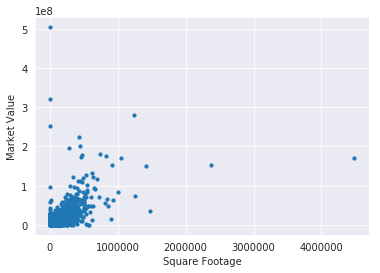

In [153]:
plt.scatter(x=bexar_df.Sq_ft,y=bexar_df.market_value,s=10)
plt.xlabel('Square Footage')
plt.ylabel('Market Value')
plt.show()

In [161]:
bexar_df[bexar_df['Sq_ft']!=0][:5]
# A lot of these appear to be plots of land

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,yoy_diff_2016,out_of_state_owner,entity_agent_binary,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__W,sos_status_code__Y,owner_owns_multiple
0,100011,R,2019,00002-000-0013,83346,KEYSTONE SCHOOL,0,0,NaN,119 E CRAIG PL,...,21060.00000,0,0,1,0,0,0,0,0,1
1,100012,R,2019,00002-000-0020,2851023,GONZALEZ MANUELA AGUILAR,0,0,NaN,216 1/2 TERRY CT,...,60540.00000,0,0,0,0,0,0,0,0,0
2,100013,R,2019,00002-000-0021,2690996,ELMERS ICEHOUSE LLC,0,0,NaN,7 W KITTY HAWK ST,...,24710.00000,0,0,0,0,0,0,0,0,1
3,100015,R,2019,00002-000-0030,2690996,ELMERS ICEHOUSE LLC,0,0,NaN,7 W KITTY HAWK ST,...,28240.00000,0,0,0,0,0,0,0,0,1
7,100030,R,2019,00002-000-0092,70026,TEXAS NEON ADVERTISING CO,0,0,NaN,PO BOX 15245,...,31330.00000,0,0,0,0,0,0,0,0,0


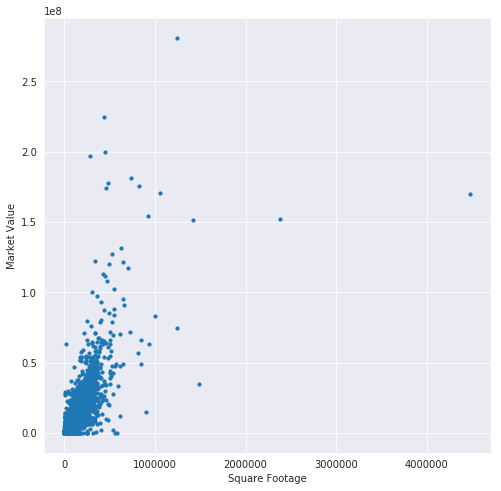

In [163]:
# Removing where square footage is 0
plt.figure(figsize=(8, 8))
plt.scatter(x=bexar_df[bexar_df['Sq_ft']!=0]['Sq_ft'],
            y=bexar_df[bexar_df['Sq_ft']!=0].market_value,s=10)
plt.xlabel('Square Footage')
plt.ylabel('Market Value')
plt.show()

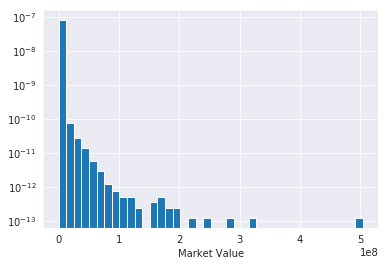

In [168]:
plt.hist(bexar_df.market_value,density=True,bins=40,log=True)
plt.xlabel('Market Value')
plt.show()

In [169]:
# Sub df to obtain market value per square foot
sq_foot_df = bexar_df[bexar_df['Sq_ft']!=0]

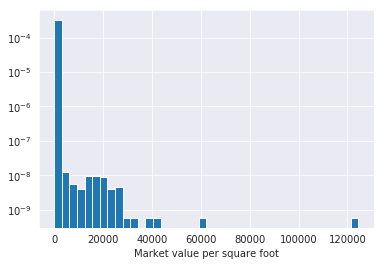

In [176]:
plt.hist(sq_foot_df.market_value/sq_foot_df['Sq_ft'],density=True,bins=40,log=True)
plt.xlabel('Market value per square foot')
plt.show()

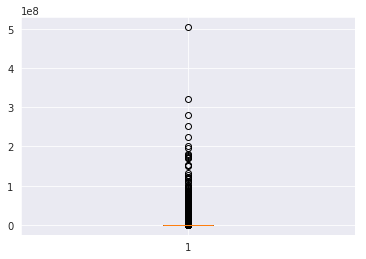

In [181]:
# Boxplot to see these outliers
plt.boxplot(bexar_df.market_value)
plt.show()

In [182]:
# A lot of outliers that need investigating
bexar_df.market_value.describe()

count      634487.00000
mean       286093.64999
std       1840267.13095
min             0.00000
25%         98380.00000
50%        162290.00000
75%        243350.00000
max     504051000.00000
Name: market_value, dtype: float64

In [187]:
# Residential property worth 504051000.00000
bexar_df[bexar_df.market_value==504051000.00000]
# This is the U.S. Army base Camp Bullis

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,yoy_diff_2016,out_of_state_owner,entity_agent_binary,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__W,sos_status_code__Y,owner_owns_multiple
362259,615484,R,2019,16386-000-0014,72248,UNITED STATES GOVERNMENT,0,0,UNION SQUARE BLDG,10101 REUNION PL,...,-337778620.00000,0,0,0,0,0,0,0,0,1


In [188]:
bexar_df[bexar_df.market_value>1000000].head()

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,yoy_diff_2016,out_of_state_owner,entity_agent_binary,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__W,sos_status_code__Y,owner_owns_multiple
44,100113,R,2019,00009-000-0182,2836009,NEWELL WINIFRED IRREVOCABLE JOHN R NEWELL FAMI...,0,0,NaN,PO BOX 830808,...,250000.00000,0,0,0,0,0,0,0,0,0
49,100118,R,2019,00009-000-0211,70080,BRAZOS DE SANTOS PARTNERS LTD,0,0,NaN,PO BOX 839925,...,98400.00000,0,0,1,0,0,0,0,0,1
57,100137,R,2019,00014-000-0022,2720951,PROBANDT PROPERTIES LLC,0,0,NaN,210 PROBANDT,...,57069.00000,0,0,1,0,0,0,0,0,0
64,100162,R,2019,00014-000-0090,70103,SALVATION ARMY INC,0,0,NaN,PO BOX 36607,...,1332940.00000,0,0,0,0,0,0,0,0,1
67,100178,R,2019,00014-000-0181,3150134,"NASSOUR JIMMY, CABOT-CHASE LTD, & OH PROBANDT ...",0,0,NaN,901 S MO PAC EXPY STE 220 BLDG 3,...,817390.00000,0,0,0,0,0,0,0,0,0


In [190]:
# 5578 properties with a market value of 0
bexar_df[bexar_df.market_value==bexar_df.market_value.min()].shape

(5578, 72)

In [191]:
bexar_df[bexar_df.market_value==bexar_df.market_value.min()].head()

,prop_id,prop_type_cd,prop_val_yr,geo_id,py_owner_id,py_owner_name,partial_owner,udi_group,py_addr_line1,py_addr_line2,...,yoy_diff_2016,out_of_state_owner,entity_agent_binary,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__W,sos_status_code__Y,owner_owns_multiple
5,100020,R,2019,00002-000-0036,70072,SAN ANTONIO RIVER AUTHORITY,0,0,NaN,100 E GUENTHER,...,0.00000,0,0,0,0,0,0,0,0,1
11,100039,R,2019,00002-000-0170,70010,CITY OF SAN ANTONIO,0,0,NaN,PO BOX 839966,...,0.00000,0,0,0,0,0,0,0,0,1
12,100040,R,2019,00002-000-0171,70010,CITY OF SAN ANTONIO,0,0,NaN,PO BOX 839966,...,0.00000,0,0,0,0,0,0,0,0,1
13,100042,R,2019,00002-000-0180,70010,CITY OF SAN ANTONIO,0,0,NaN,PO BOX 839966,...,0.00000,0,0,0,0,0,0,0,0,1
16,100045,R,2019,00004-000-0010,70010,CITY OF SAN ANTONIO,0,0,NaN,PO BOX 839966,...,0.00000,0,0,0,0,0,0,0,0,1


In [196]:
# Seems like most of these are publicly owned
bexar_df[bexar_df.market_value==bexar_df.market_value.min()].py_owner_name.value_counts()[:30]

CITY OF SAN ANTONIO                             1813
STATE OF TEXAS                                   349
SAN ANTONIO RIVER AUTHORITY                      152
BEXAR COUNTY                                     145
SAN ANTONIO ISD                                  110
NORTHSIDE I S D                                   97
SAN ANTONIO HOUSING AUTHORITY                     80
NORTH EAST I S D                                  79
CITY OF SAN ANTONIO (SECURITY AIR PARK)           57
UNITED STATES GOVERNMENT                          57
CITY PUBLIC SERVICE BOARD                         53
EDGEWOOD I S D                                    53
CITY OF SAN ANTONIO/SAN ANTONIO WATER SYSTEM      44
HARLANDALE I S D                                  41
CITY OF UNIVERSAL CITY                            41
UNITED STATES OF AMERICA                          37
BROOKS DEVELOPMENT AUTHORITY                      34
ALAMO COMMUNITY COLLEGE DISTRICT                  32
SAN ANTONIO WATER SYSTEM                      

In [198]:
bexar_df[bexar_df.market_value>bexar_df.market_value.min()].market_value.describe()

count      628909.00000
mean       288631.10832
std       1848211.96992
min             4.00000
25%        100130.00000
50%        163400.00000
75%        244550.00000
max     504051000.00000
Name: market_value, dtype: float64

In [ ]:
bexar_df.market_value.sort_values()

##### Unusual Price Fluctuations
Need to get percent property value changes rather than absolute; will need to add back into the build script.

In [ ]:
bexar_df

#### Visualize Labeled Properties on Map